In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load the dataset
data = pd.read_csv('../Data/biweekly_air_quality_data.csv')


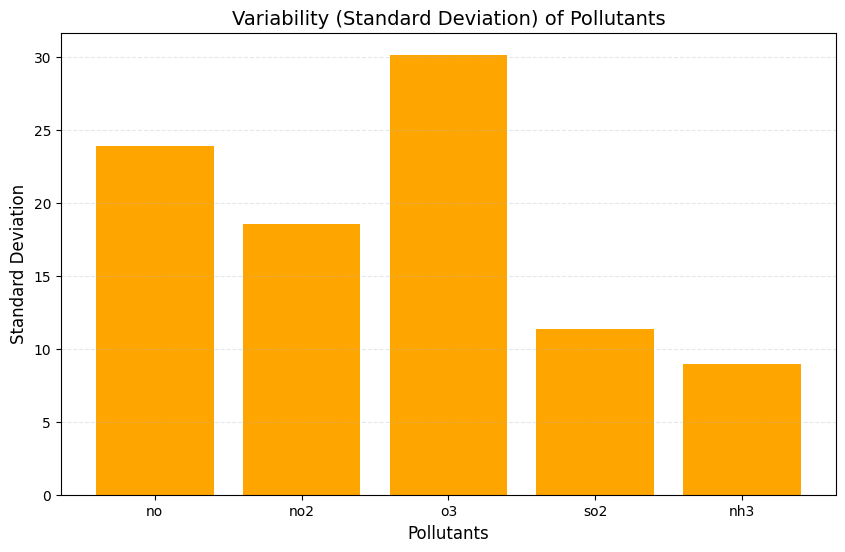

In [3]:
# Calculate standard deviation for each pollutant
pollutant_variability = data[[ 'no', 'no2', 'o3', 'so2', 'nh3']].std()

# Plot standard deviation
plt.figure(figsize=(10, 6))
plt.bar(pollutant_variability.index, pollutant_variability.values, color='orange')
plt.title('Variability (Standard Deviation) of Pollutants', fontsize=14)
plt.xlabel('Pollutants', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


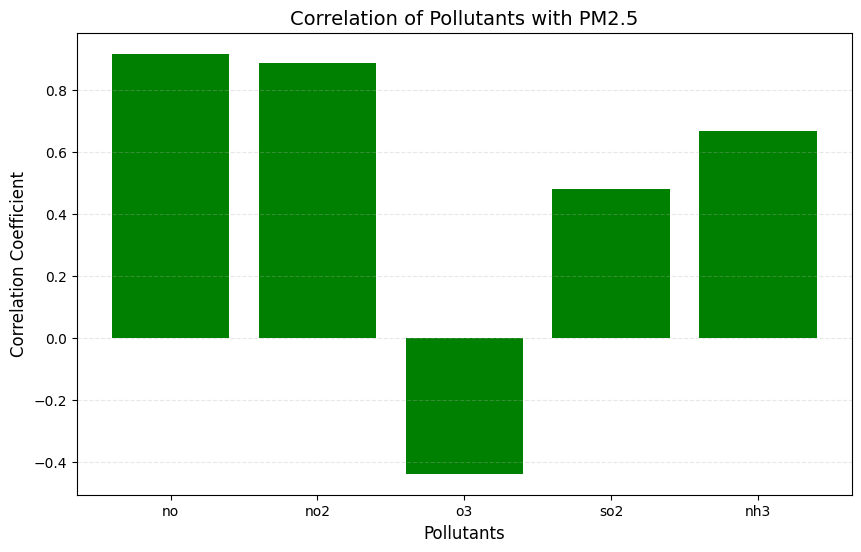

In [5]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Calculate correlation with PM2.5
correlation_with_pm25 = numeric_data.corr()['pm2_5'].drop(['pm2_5', 'pm10', 'co'])

# Plot correlation coefficients
plt.figure(figsize=(10, 6))
plt.bar(correlation_with_pm25.index, correlation_with_pm25.values, color='green')
plt.title('Correlation of Pollutants with PM2.5', fontsize=14)
plt.xlabel('Pollutants', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


In [27]:
# Convert 'date' to datetime and extract year
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year

# Example pollutants to analyze
pollutants = ['no2', 'so2', 'no']

# Summarize data into monthly averages
data['month'] = data['date'].dt.month
monthly_avg = data.groupby(['year', 'month'])[pollutants].mean().reset_index()

# Display the summarized data
print(monthly_avg)


    year  month         no2        so2         no
0   2020     11   75.690000  61.500000  24.450000
1   2020     12   85.870000  68.505000  56.030000
2   2021      1   66.910000  61.745000  46.605000
3   2021      2   87.530000  72.295000  55.595000
4   2021      3   67.260000  66.265000  38.365000
5   2021      4   49.900000  59.630000  11.685000
6   2021      5   61.296667  70.496667  11.200000
7   2021      6   58.730000  76.090000  11.710000
8   2021      7   41.940000  56.830000   8.735000
9   2021      8   56.405000  69.930000  25.790000
10  2021      9   50.405000  63.935000  19.675000
11  2021     10   66.173333  64.726667  32.960000
12  2021     11  104.700000  85.345000  66.440000
13  2021     12   94.010000  79.440000  70.680000
14  2022      1   76.845000  70.250000  77.705000
15  2022      2   73.255000  66.045000  58.300000
16  2022      3   65.410000  59.165000  24.705000
17  2022      4   59.990000  68.130000  18.245000
18  2022      5   45.406667  60.366667   7.470000


In [22]:
def simpsons_method(y, x):
    """
    Simpson's Method for Numerical Integration.
    Parameters:
    - y: List of function values (e.g., pollutant levels).
    - x: List of corresponding x-values (e.g., months).
    Returns:
    - Approximation of the integral.
    """
    if len(x) < 3 or len(x) % 2 == 0:
        raise ValueError("Simpson's method requires an odd number of intervals.")

    h = (x[-1] - x[0]) / (len(x) - 1)
    integral = y[0] + y[-1]

    for i in range(1, len(y) - 1):
        weight = 4 if i % 2 != 0 else 2
        integral += weight * y[i]

    return (h / 3) * integral


In [28]:
# Divide each year into equal intervals
num_intervals = 6  # Divide the year into sixths
interval_exposure = {}

for pollutant in pollutants:
    pollutant_exposure = {}
    for year in monthly_avg['year'].unique():
        # Filter data for the year
        year_data = monthly_avg[monthly_avg['year'] == year][pollutant].values

        # If data is missing, interpolate to fill the gaps
        if len(year_data) < num_intervals:
            x_original = np.linspace(1, len(year_data), len(year_data))
            x_new = np.linspace(1, num_intervals, num_intervals)
            year_data = np.interp(x_new, x_original, year_data)

        # Ensure odd number of intervals for Simpson's Method
        if len(year_data) % 2 == 0:
            year_data = np.append(year_data, year_data[-1])  # Duplicate last value to make odd

        # Create x values representing the intervals
        x = np.linspace(1, num_intervals, len(year_data))

        # Compute cumulative exposure using Simpson's Method
        try:
            pollutant_exposure[year] = simpsons_method(year_data, x)
        except ValueError as e:
            print(f"Error computing Simpson's Method for year {year}: {e}")
            pollutant_exposure[year] = None

    interval_exposure[pollutant] = pollutant_exposure

# Display results
for pollutant, exposure in interval_exposure.items():
    print(f"Cumulative exposure for {pollutant.upper()} (Divided into {num_intervals} Intervals):")
    for year, value in exposure.items():
        if value is not None:
            print(f"  Year {year}: {value:.2f}")
        else:
            print(f"  Year {year}: Not computable")

Cumulative exposure for NO2 (Divided into 6 Intervals):
  Year 2020: 426.52
  Year 2021: 342.10
  Year 2022: 318.70
  Year 2023: 346.42
Cumulative exposure for SO2 (Divided into 6 Intervals):
  Year 2020: 340.58
  Year 2021: 349.36
  Year 2022: 318.60
  Year 2023: 303.42
Cumulative exposure for NO (Divided into 6 Intervals):
  Year 2020: 271.38
  Year 2021: 172.19
  Year 2022: 163.26
  Year 2023: 305.90


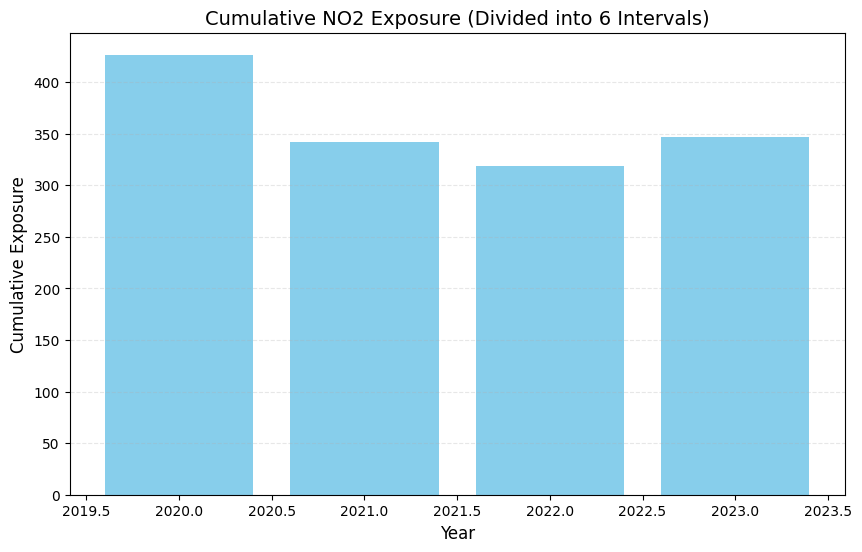

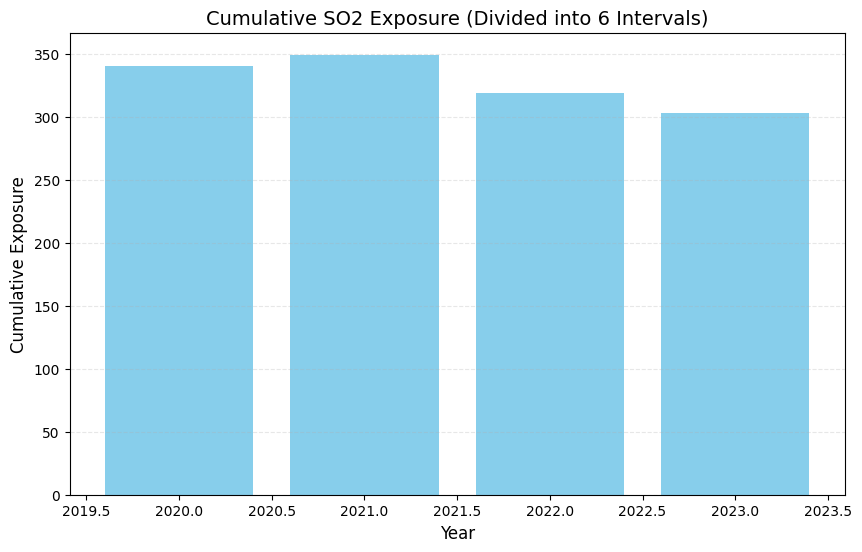

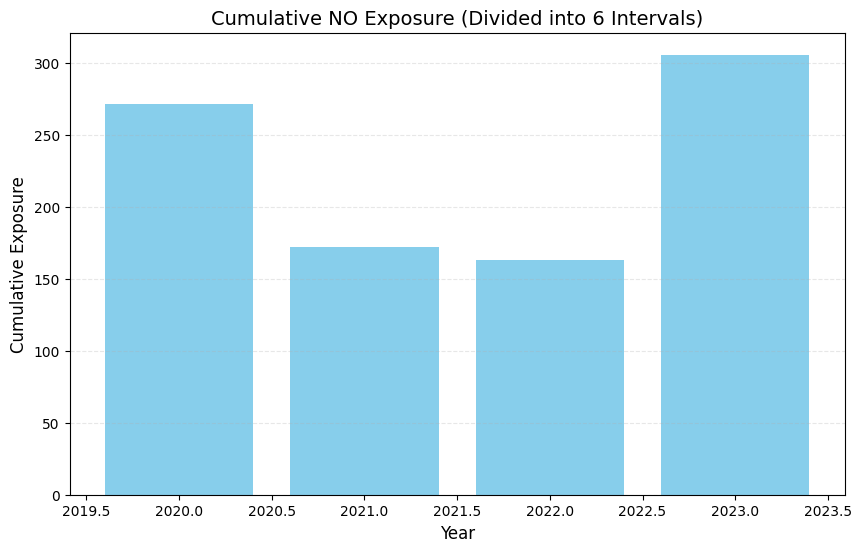

In [29]:
# Visualization
for pollutant, exposure in interval_exposure.items():
    years = list(exposure.keys())
    values = [exposure[year] if exposure[year] is not None else 0 for year in years]

    plt.figure(figsize=(10, 6))
    plt.bar(years, values, color='skyblue')
    plt.title(f'Cumulative {pollutant.upper()} Exposure (Divided into {num_intervals} Intervals)', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Cumulative Exposure', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

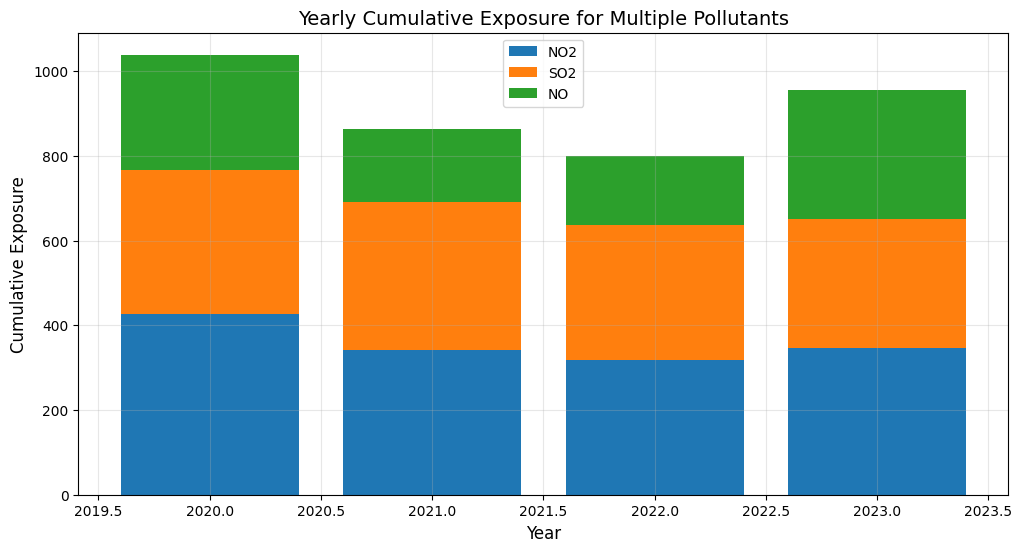

In [30]:
# Stacked bar chart for cumulative exposure of multiple pollutants
years = list(interval_exposure[pollutants[0]].keys())
pollutant_values = {pollutant: [interval_exposure[pollutant][year] if interval_exposure[pollutant][year] is not None else 0 for year in years] for pollutant in pollutants}

plt.figure(figsize=(12, 6))
bottom = np.zeros(len(years))
for pollutant in pollutants:
    plt.bar(years, pollutant_values[pollutant], bottom=bottom, label=pollutant.upper())
    bottom += np.array(pollutant_values[pollutant])

plt.title('Yearly Cumulative Exposure for Multiple Pollutants', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Exposure', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


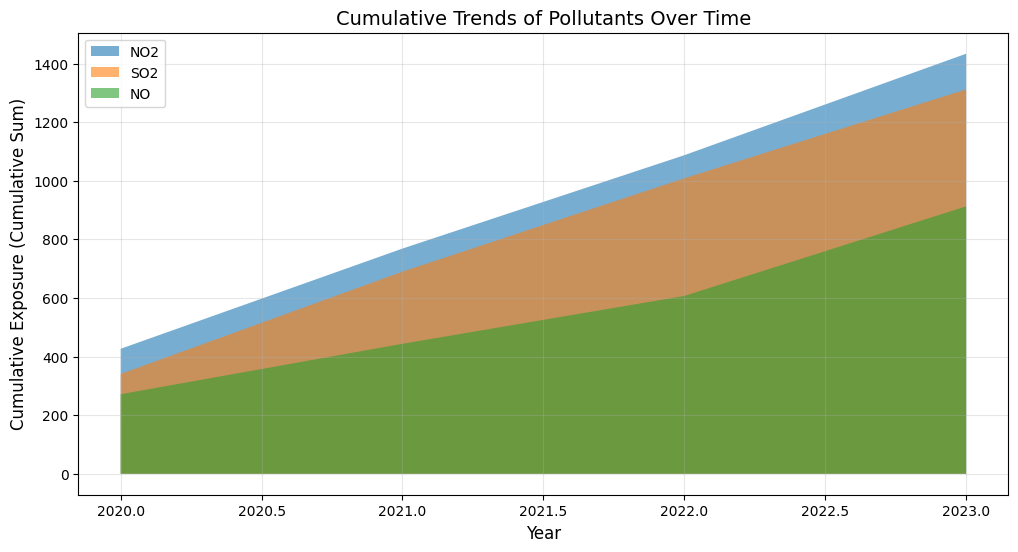

In [31]:
# Area chart showing cumulative trends over time
cumulative_trends = {pollutant: np.cumsum([interval_exposure[pollutant][year] if interval_exposure[pollutant][year] is not None else 0 for year in years]) for pollutant in pollutants}

plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.fill_between(years, cumulative_trends[pollutant], label=pollutant.upper(), alpha=0.6)

plt.title('Cumulative Trends of Pollutants Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Exposure (Cumulative Sum)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [35]:
# # Compute exposure build-up for one year (e.g., 2020) using Simpson's Rule
# pollutant = 'pm2_5'  # Choose a pollutant
# year = 2022  # Choose a year

# # Filter and prepare data for the selected year
# year_data = monthly_avg[monthly_avg['year'] == year][pollutant].values
# num_intervals = 6
# if len(year_data) < num_intervals:
#     x_original = np.linspace(1, len(year_data), len(year_data))
#     x_new = np.linspace(1, num_intervals, num_intervals)
#     year_data = np.interp(x_new, x_original, year_data)

# # Ensure odd intervals for Simpson's Rule
# if len(year_data) % 2 == 0:
#     year_data = np.append(year_data, year_data[-1])
# x = np.linspace(1, num_intervals, len(year_data))

# # Calculate cumulative exposure at each interval
# cumulative_exposure = []
# for i in range(1, len(x) + 1):
#     try:
#         cumulative_exposure.append(simpsons_method(year_data[:i], x[:i]))
#     except ValueError:
#         cumulative_exposure.append(None)

# # Plot the cumulative exposure build-up
# plt.figure(figsize=(10, 6))
# plt.plot(x, cumulative_exposure, marker='o', color='blue', label=f'Cumulative PM2.5 Exposure ({year})')
# plt.title(f'Cumulative Exposure Build-Up ({pollutant.upper()}, {year})', fontsize=14)
# plt.xlabel('Interval', fontsize=12)
# plt.ylabel('Cumulative Exposure', fontsize=12)
# plt.grid(alpha=0.3)
# plt.legend()
# plt.show()
